Potential improvments,
try doing the regex finds as a single find all operation, this appears to be quicker

In [332]:
import pandas as pd
import numpy as np
import gpxpy
import os
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from tqdm.autonotebook import tqdm
tqdm.pandas()

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [428]:
MASS = 78
BIKE_MASS = 10
TOT_MASS = mass + bike_mass
G = 9.81
AREA = 0.4
EARTH_R = 6371000
C_d = 1.0
RHO = 1.225
WHEEL_DIAM = 0.622*np.pi
FRONT_RING_TEETH = 53

ESTIMATED_MAX_POWER = 700

FILEPATH_r = 'data/*.gpx'

LAT_r = r'^\s+(?:lat=\"(?P<lat>[+-]?\d+.?\d+)\")?'
LON_r = r'\s+(?:lon=\"(?P<lon>[+-]?\d+.?\d+)\")?>'
ELE_r = r'(?:\n\s+<ele>(?P<ele>[+-]?\d+.?\d+)<\/ele>)?'
TIME_r = r'(?:\n\s+<time>(?P<time>.+)<\/time>)?'
EXT_START_r = r'(?:\n\s+<extensions>)?'
TRK_EXT_START_r = r'(?:\n\s+<gpxtpx:TrackPointExtension>)?'
TEMP_r = r'(?:\n\s+<gpxtpx:atemp>(?P<temp>.+)<\/gpxtpx:atemp>)?'
HR_r = r'(?:\n\s+<gpxtpx:hr>(?P<hr>.+)<\/gpxtpx:hr>)?'
CAD_r = r'(?:\n\s+<gpxtpx:cad>(?P<cad>.+)<\/gpxtpx:cad>)?'
EXT_END_r = r'(?:\n\s+<\/gpxtpx:TrackPointExtension>)?'
TRK_EXT_END_r = r'(?:\n\s+<\/extensions>)?'

POINT_r = LAT_r + LON_r + ELE_r + TIME_r + EXT_START_r + TRK_EXT_START_r + TEMP_r + HR_r + CAD_r + EXT_END_r + TRK_EXT_END_r
POINT_r = r'(?:'+ POINT_r + ')|$'
POINT_r = re.compile(POINT_r)

LAT_r = re.compile(r'(?:lat=\"(?P<lat>[+-]?\d+.?\d+)\")|$')
LON_r = re.compile(r'(?:lon=\"(?P<lon>[+-]?\d+.?\d+)\")|$')
ELE_r = re.compile(r'(?:<ele>(?P<ele>[+-]?\d+.?\d+)<\/ele>)|$')
TIME_r = re.compile(r'(?:<time>(?P<time>.+)<\/time>)|$')
TEMP_r = re.compile(r'(?:<gpxtpx:atemp>(?P<temp>.+)<\/gpxtpx:atemp>)|$')
HR_r = re.compile(r'(?:<gpxtpx:hr>(?P<hr>.+)<\/gpxtpx:hr>)|$')
CAD_r = re.compile(r'(?:<gpxtpx:cad>(?P<cad>.+)<\/gpxtpx:cad>)|$')



In [683]:
def gpx_line_split(gpx_df_line):
    gpx_df_line['lat']=LAT_r.search(gpx_df_line['points']).group('lat')
    gpx_df_line['lon']=LON_r.search(gpx_df_line['points']).group('lon')
    gpx_df_line['ele']=ELE_r.search(gpx_df_line['points']).group('ele')
    gpx_df_line['time']=TIME_r.search(gpx_df_line['points']).group('time')
    gpx_df_line['temp']=TEMP_r.search(gpx_df_line['points']).group('temp')
    gpx_df_line['hr']=HR_r.search(gpx_df_line['points']).group('hr')
    gpx_df_line['cad']=CAD_r.search(gpx_df_line['points']).group('cad')
    return gpx_df_line

def gpx_line_split_f(gpx_df_line):
    match = POINT_r.search(gpx_df_line['points'])
    gpx_df_line['lat']=match.group('lat')
    gpx_df_line['lon']=match.group('lon')
    gpx_df_line['ele']=match.group('ele')
    gpx_df_line['time']=match.group('time')
    gpx_df_line['temp']=match.group('temp')
    gpx_df_line['hr']=match.group('hr')
    gpx_df_line['cad']=match.group('cad')
    return gpx_df_line

def generate_df(file, filename):
    data = pd.DataFrame(file.split('<trkpt'), columns =['points'])
    data['filename'] = filename
    return data

def create_cols(data):
    data = data.progress_apply(gpx_line_split_f, axis=1)
    return data
    
def cleanse_data(data):
    data = data.fillna(method='bfill')
    data = data.fillna(method='ffill')
    data['lon'] = pd.to_numeric(data['lon'])
    data['lat'] = pd.to_numeric(data['lat'])
    data['ele'] = pd.to_numeric(data['ele'])
    data['hr'] = pd.to_numeric(data['hr'])
    data['cad'] = pd.to_numeric(data['cad'])
    data['temp'] = pd.to_numeric(data['temp'])
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=False)
    return data

def add_power_gears(data, keep_large=True, large_val=1000):
#     diffs
    data['dlat'] = np.deg2rad(data['lat'].diff())
    data['dlon'] = np.deg2rad(data['lon'].diff())
    data['dele'] = data['ele'].diff()
    data['dtime'] = data['time'].diff()
# distance prereqs
    h_d_lat_2 = np.power(np.sin(data['dlat']/2),2)
    cos_cos = np.power(np.cos(np.deg2rad(data['lat'])),2)
    h_d_lon_2 = np.power(np.sin(data['dlon']/2),2)
    cc_h_d_lon_2 = np.multiply(cos_cos, h_d_lon_2)
# add dist and speed
    data['dist'] = 2*EARTH_R*np.arcsin(np.sqrt(cc_h_d_lon_2+h_d_lat_2))
    data['speed m/s'] = data['dist']/data['dtime'].dt.total_seconds()
    data['speed km/h'] = data['speed m/s']*3.6

# add power
    data['KE'] = np.power(data['speed m/s'],2)*TOT_MASS*0.5
    data['GPE'] = TOT_MASS*g*data['ele']
    P_drag = 0.5*C_d*AREA*RHO*np.power(data['speed m/s'],3)
    P_kin = (data['KE'].diff() + data['GPE'].diff())/data['dtime'].dt.total_seconds()
    power = P_drag + P_kin
    data['Power W'] = power
    data['Power W'] = data['Power W'].clip(lower = 0, upper = large_val)
    if not keep_large:
        data['Power W'] = data['Power W'].replace(large_val, np.nan)

# adding gears
    data['gear ratio'] = data['cad']/data['speed m/s']/60*WHEEL_DIAM*FRONT_RING_TEETH
    data['gear ratio'] = data['gear ratio'].clip(upper = 40)
    return data

def gen_power_cols(data, times):
    for time in tqdm(times):
        data[str(time) + 's Power W'] = data['Power W'].rolling(str(time)+'s', min_periods=int(round(time/4))).mean()
    return data

def add_all(data, times):
    data = create_cols(data)
    data = cleanse_data(data)
    data = add_power_gears(data, keep_large=False, large_val=700)
    data = gen_power_cols(data, times)
    return data

In [583]:
paths = glob.glob(FILEPATH_r)

times = list(np.arange(5, 30, 1)) + list(np.arange(30, 180, 10)) + list(np.arange(180, 600, 30)) + list(np.arange(600, 1260, 60))


all_data = None

for path in tqdm(paths):
    with open(path, 'r') as f:
        gpx_data = f.read()
        data = generate_df(gpx_data, path)
        data = add_all(data, times)
        if all_data is None:
            all_data = data
        else:
            all_data = all_data.append(data)

KeyboardInterrupt: 

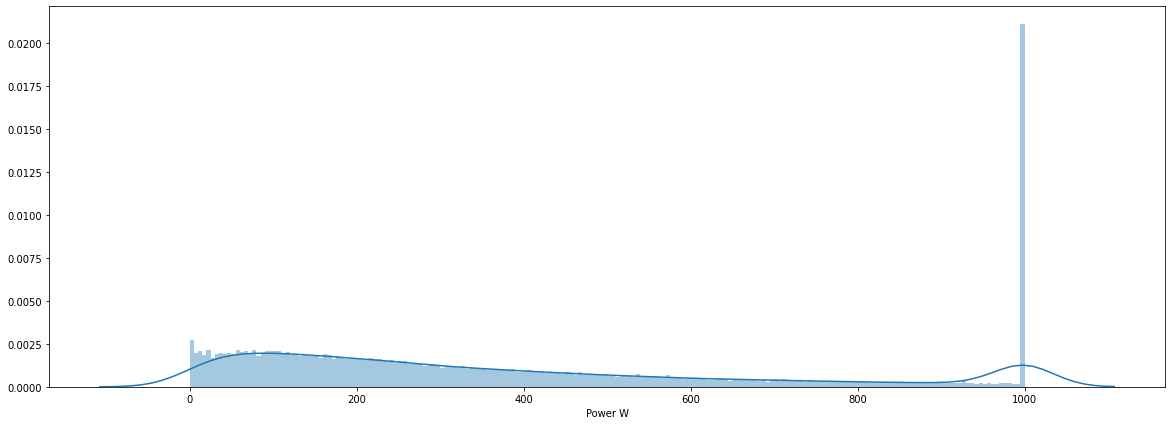

In [664]:
fig, ax = plt.subplots(figsize = (20,7))
sns.distplot(all_data[all_data['Power W']>0]['Power W'], bins = 200)

In [653]:
col_names = [str(time)+'s Power W' for time in times]

power_curves = new_data.groupby('filename')[col_names].max()

In [654]:
power_curves = power_curves.transpose()
power_curves['row_names'] = times

In [660]:
pd.melt(power_curves, ['row_names'])

,row_names,filename,value
0,5,data/20160314-121204-Ride.gpx,276.724561
1,6,data/20160314-121204-Ride.gpx,232.068457
2,7,data/20160314-121204-Ride.gpx,231.118726
3,8,data/20160314-121204-Ride.gpx,218.219305
4,9,data/20160314-121204-Ride.gpx,213.923022
...,...,...,...
3771,900,data/Gentle_Sunday_afternoon_amidst_the_glorio...,143.299608
3772,960,data/Gentle_Sunday_afternoon_amidst_the_glorio...,140.488332
3773,1020,data/Gentle_Sunday_afternoon_amidst_the_glorio...,141.327928
3774,1080,data/Gentle_Sunday_afternoon_amidst_the_glorio...,139.997706


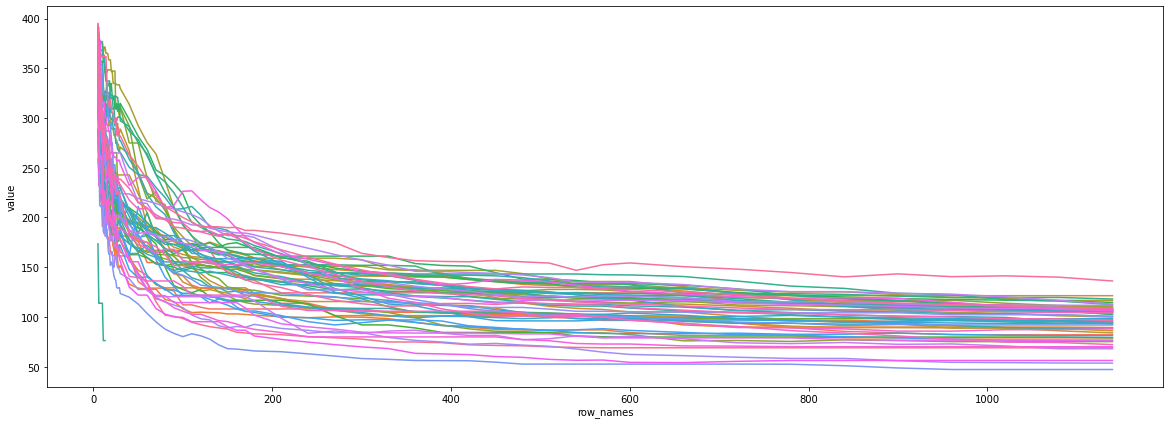

In [682]:
fig, ax = plt.subplots(figsize=(20,7))

sns.lineplot(x = 'row_names', y = 'value',hue = 'filename', data=pd.melt(power_curves,['row_names']), legend=False)

In [630]:
# file_grouped = all_data.groupby('filename')    
# file_grouped = [file_grouped.get_group(x) for x in file_grouped.groups]



In [681]:
# new_data = None

# for df in file_grouped:
#     this_df = gen_power_cols(add_power_gears(df, keep_large=False, large_val=400), times)
#     if new_data is None:
#         new_data = this_df
#     else:
#         new_data = new_data.append(this_df)

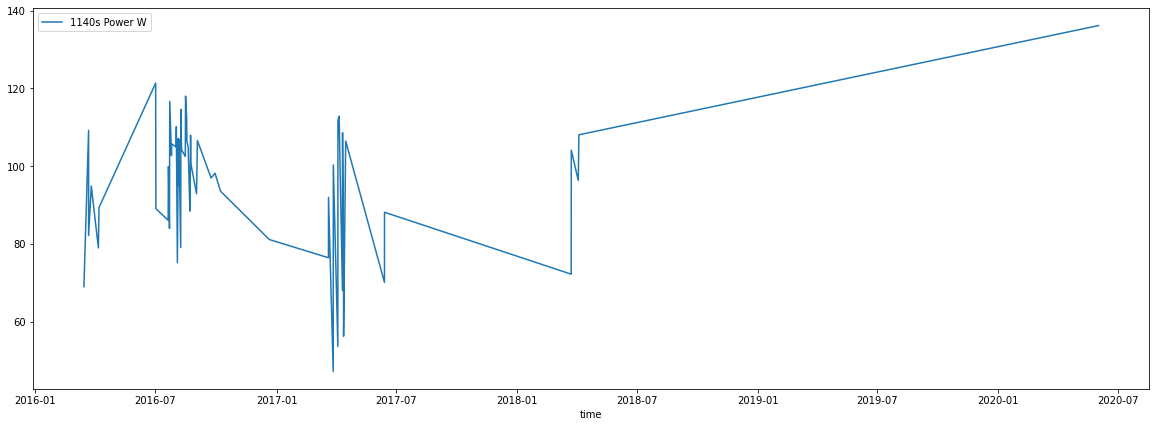

In [680]:
fig, ax = plt.subplots(figsize=(20,7))

sns.lineplot(data = new_data.groupby('filename')[['1140s Power W', 'time']].max().set_index('time'))

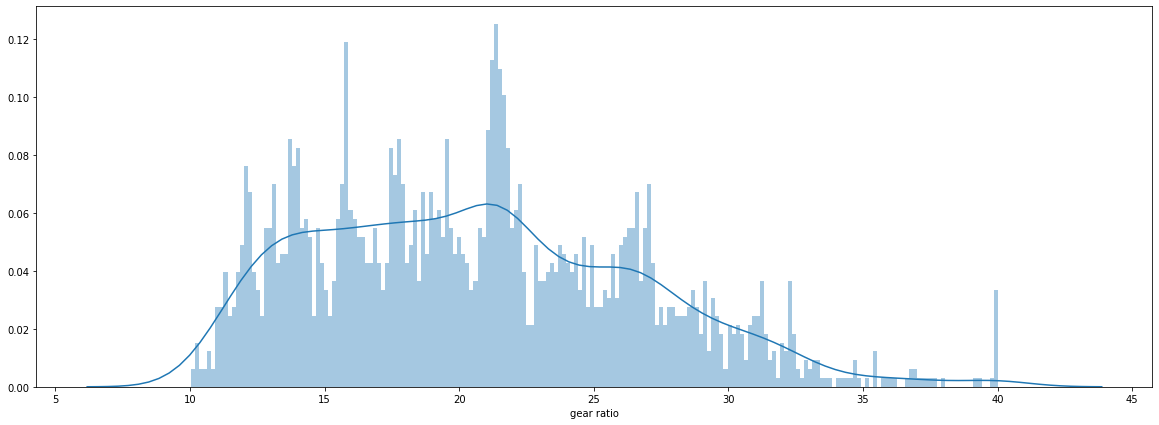

In [677]:
fig, ax = plt.subplots(figsize=(20,7))


sns.distplot(new_data[new_data['gear ratio']>10]['gear ratio'], bins=200)

In [690]:
CAD_r.findall(gpx_data)

['', '']